In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"


from typing import Any, Callable, List, Tuple, Dict

from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST, MNIST



from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils

import lightning.pytorch as L
from einops import rearrange, reduce, repeat

torch.manual_seed(2023)
np.random.seed(2023)
torch.set_float32_matmul_precision('medium')


/home/shawon/.cache/pypoetry/virtualenvs/experiments-Ob0g23dR-py3.12/lib/python3.12/site-packages/einops/einops.py:827: SyntaxWarning: invalid escape sequence '\s'
  """


In [2]:
# trainset = FashionMNIST(root='~/.cache/torchvision_cache', train=True, download=True,
#                         transform=transforms.Compose([
#                         transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))


trainset = MNIST(root="~/.cache/torchvision_cache",
                      download=True, train=True, transform=transforms.ToTensor())


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 10655698.36it/s]


Extracting /home/shawon/.cache/torchvision_cache/MNIST/raw/train-images-idx3-ubyte.gz to /home/shawon/.cache/torchvision_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 283288.11it/s]


Extracting /home/shawon/.cache/torchvision_cache/MNIST/raw/train-labels-idx1-ubyte.gz to /home/shawon/.cache/torchvision_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2657021.20it/s]


Extracting /home/shawon/.cache/torchvision_cache/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/shawon/.cache/torchvision_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 9024409.65it/s]

Extracting /home/shawon/.cache/torchvision_cache/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/shawon/.cache/torchvision_cache/MNIST/raw



torch.Size([1, 28, 28])


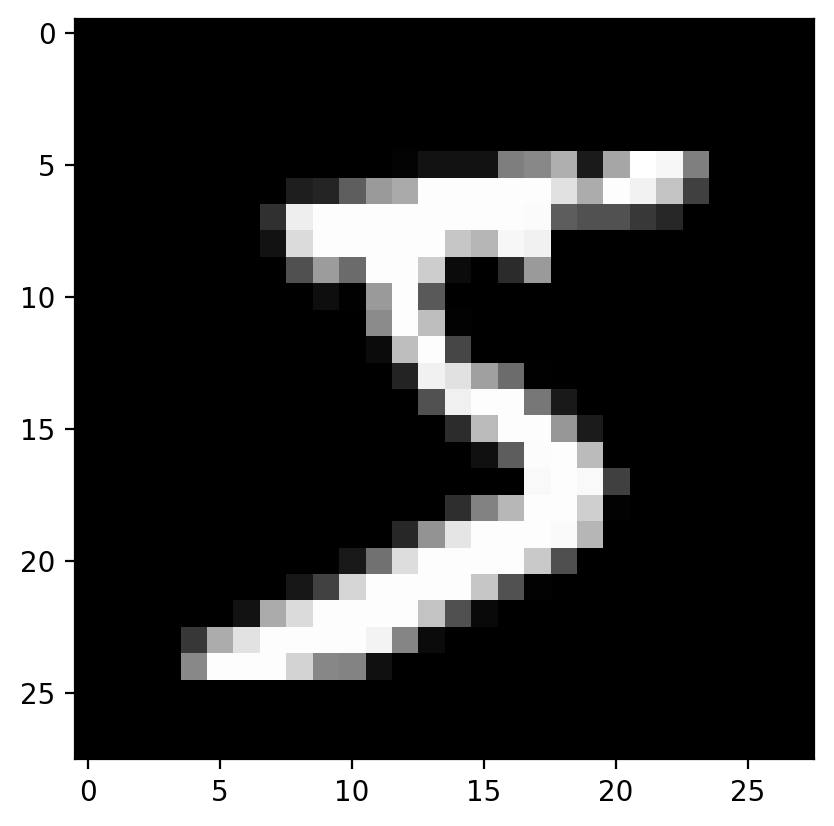

In [3]:
plt.imshow(trainset[0][0].squeeze(), cmap='gray')
print(trainset[0][0].size())


In [4]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)


In [5]:
class VAELoss(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
    def forward(self, x: torch.Tensor, x_hat: torch.Tensor, mean: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        reproduction_loss = F.binary_cross_entropy(input=x_hat, target=x, reduction="sum")
        kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        
        return reproduction_loss + kl_divergence


In [6]:
from typing import Any

from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler


class VAE(L.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            
        )
        
        # latent space
        self.latent_mean = nn.Linear(512, 256)
        self.latent_log_var = nn.Linear(512, 256)
        
        
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.LeakyReLU(0.2),
            nn.Sigmoid()
        )
        
    
    def reparameterisation(self, mean: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        # assuming log_var
        # un-log and then sqrt to get the std-dev 
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(self.device)
        return mean + eps * std
        
        
    def forward(self, x: torch.Tensor) -> Any:
        out = self.encoder(x)
        
        mean = self.latent_mean(out)
        mean = F.leaky_relu(mean, 0.2)
        
        log_var = self.latent_log_var(out)
        log_var = F.leaky_relu(log_var, 0.2)
        
        z = self.reparameterisation(mean, log_var)
        
        x_hat = self.decoder(z)
        
        
        return x_hat, mean, log_var
    
    
    def configure_optimizers(self) -> OptimizerLRScheduler:
        return optim.AdamW(self.parameters(), lr=1e-3)
    
    
    def training_step(self, batch, batch_idx) -> STEP_OUTPUT:
        x, _ = batch
                
        x = torch.flatten(x, start_dim=1)
        
        x_hat, mean, log_var = self(x)
        
        loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
        kl = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        loss += kl
        
        self.log('train_loss', loss, prog_bar=True)
        
        return {
            "loss": loss,
            "log": {
                "Loss/Training": loss
            }
        }


# model = VAE()
# x = torch.randn(8, 784)
# y = torch.zeros(8, )

# x_hat, mean, log_var = model(x)
# print(x_hat)

# loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
# kl = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
# print(loss + kl)


In [7]:
def train() -> Any:
    logger = L.loggers.TensorBoardLogger("tb_logs", name="vae_fashion_mnist", log_graph=True)
    
    
    model = VAE()
    trainer = L.Trainer(max_epochs=5, devices=1, accelerator="gpu", logger=logger)
    # trainer = L.Trainer(max_epochs=5, devices=1, accelerator="cpu", logger=logger)
    trainer.fit(model, trainloader)
    
    return model


model = train()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/vae_fashion_mnist
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | encoder        | Sequential | 664 K  | train
1 | latent_mean    | Linear     | 131 K  | train
2 | latent_log_var | Linear     | 131 K  | train
3 | decoder        | Sequential | 796 K  | train
------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.895     Total estimated model params size (MB)
/home/shawon/.cache/pypoetry/virtualenvs/experiments-Ob0g23dR-py3.12/lib/python3.12/site-packages/lightning/pytorch/loggers/tensorboard.py:194: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
/home/shawon/.cache/pypoetry

Training: |                                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [8]:
# %load_ext tensorboard
# %tensorboard --logdir tb_logs/


torch.Size([28, 28])


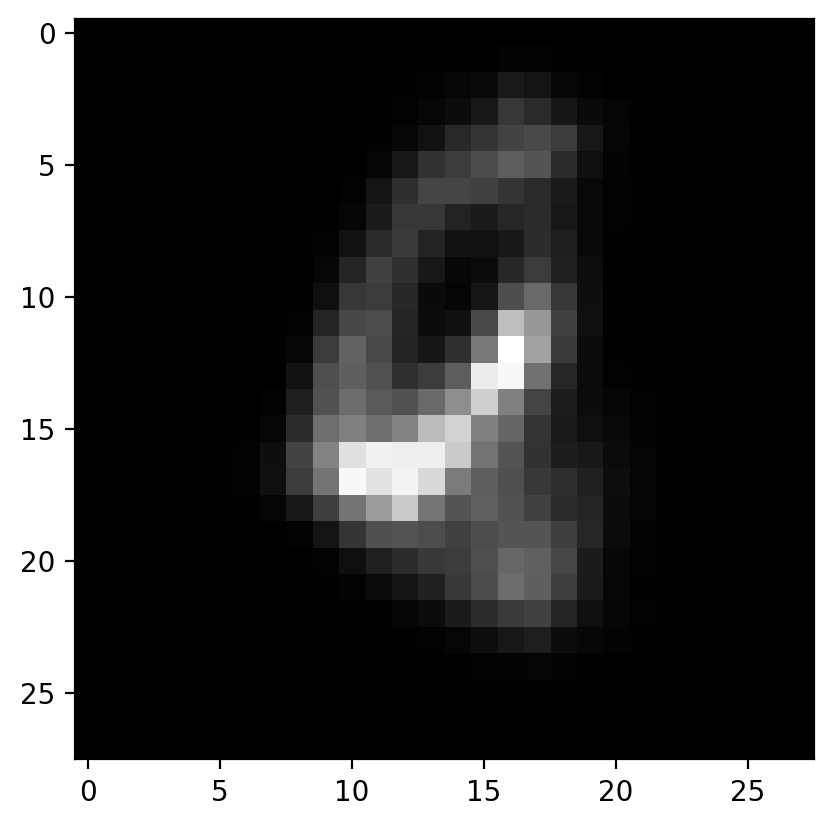

In [8]:
with torch.no_grad():
    x = torch.randn(256, ).to(model.device)
    out = model.decoder(x)
    
    
    
    out = torch.unflatten(out, -1, (28, 28))
    print(out.size())
    
    plt.imshow(out, cmap='gray')


5


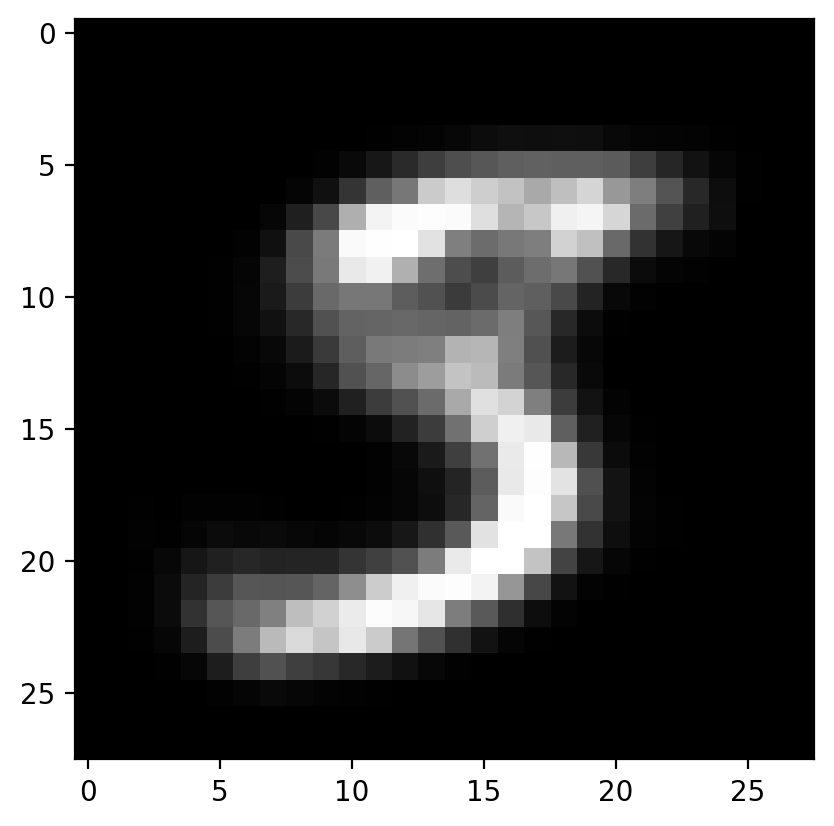

In [9]:
with torch.no_grad():
    image = torch.flatten(trainset[0][0])
    print(trainset[0][1])
    out, _ , _ = model(image)
    
    out = torch.unflatten(out, -1, (28, 28))
    
plt.imshow(out, cmap="gray")


In [10]:
@torch.no_grad()
def inference(image: torch.Tensor) -> torch.Tensor:
    flattened_image = torch.flatten(image)
    out, _ , _ = model(flattened_image)
    out = torch.unflatten(out, -1, (28, 28))

    return out

In [12]:
inference(trainset[0][0]).shape

torch.Size([28, 28])

In [28]:
from einops import rearrange

def randomly_pick_n(n: int=8, max=len(trainset)) -> Tuple:
    indexes = torch.randint(0, max, size=(n, )).tolist()
    selection = [trainset[i][0] for i in indexes]
    actuals = [torch.from_numpy(np.array(im, dtype=np.float32)) for im in selection]
    generated = [inference(im) for im in selection]

    stacked_generated = torch.stack(generated)
    stacked_actuals = torch.stack(actuals)

    # drop the extra dim in actuals
    stacked_actuals = rearrange(stacked_actuals, "b 1 h w -> b h w")
    
    return stacked_generated, stacked_actuals

In [29]:
generated, actuals = randomly_pick_n()
print(generated.size())
print(actuals.size())

torch.Size([8, 28, 28])
torch.Size([8, 28, 28])


In [31]:
def comparison_plot(generated: list, actuals: list) -> None:
    fig = plt.figure(1, figsize=[12, 6])
    fig.tight_layout()
    
    for idx, gen in enumerate(generated):
        ax = fig.add_subplot(1, len(generated), idx + 1)
        ax.set_title(f"generated_{idx}")
        plt.imshow(gen)
        plt.axis("off")
        
    for idx, act in enumerate(actuals):
        ax = fig.add_subplot(2, len(actuals), idx + 1)
        ax.set_title(f"actual_{idx}")
        plt.imshow(act)
        plt.axis("off")
    
    fig.suptitle("Actual (upper) vs Generated(lower)")

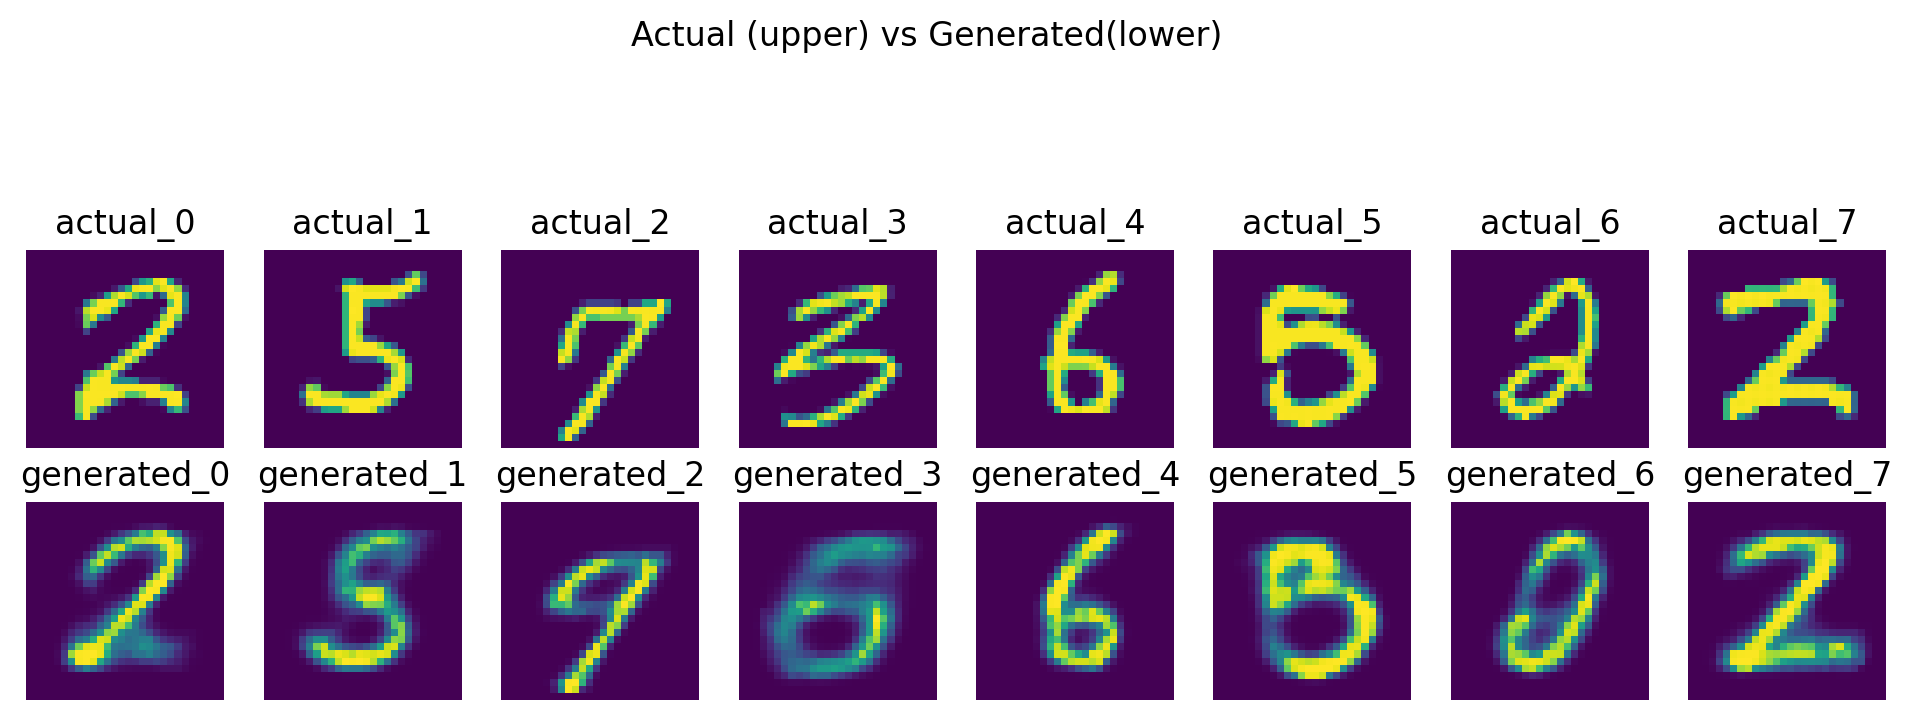

In [32]:
comparison_plot(generated.tolist(), actuals.tolist())